# DDPM Notebook

Datasets used from torchvision of CIFAR10

## AE

## VAE

## reverse
## forward
## loss

## Scheduler

In [1]:
## Scheduler
'''
sequentially add noise to images
precomputed values used
'''


import torch.nn.functional as F
import torch

def get_index_from_list(vals, t, x_shape):
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,)* (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumulative_products_t = get_index_from_list(sqrt_alphas_cumulative_products, t, x_0.shape)
  sqrt_one_minus_alphas_cumulative_products_t = get_index_from_list(
      sqrt_one_minus_alphas_cumulative_products, t, x_0.shape
  )
  ## formulae for image augged looks like sqrt(pi(alpha_t)) * x_t-1 * sqrt(pi(1-alpha_t)) * noise~N(0,1)
  return sqrt_alphas_cumulative_products_t.to(device) * x_0.to(device) \
      + sqrt_one_minus_alphas_cumulative_products_t.to(device) * noise.to(device), noise.to(device)

In [2]:
T = 300 ## according to the paper

### SOO MMANNYY PRECOMPUTEDD VALUESS TO TRACKKKK
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_cumulative_products = torch.cumprod(alphas, axis=0)
alphas_cumulative_products_prev = F.pad(alphas_cumulative_products[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumulative_products = torch.sqrt(alphas_cumulative_products)
sqrt_one_minus_alphas_cumulative_products = torch.sqrt(1. - alphas_cumulative_products)
## in paper its B * (1 - pi(alphas_(t-1)) / (1 - pi(alphas_t))
posterior_variance = betas * (1. - alphas_cumulative_products_prev) / (1. - alphas_cumulative_products)

## Dataloader
load the dataset, sample tensor images, yada yada crap

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Subset


IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # Define the transformation pipeline
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    # Load CIFAR10 dataset without splitting
    cifar10_dataset = torchvision.datasets.CIFAR10(root=".", download=True, transform=data_transform)

    # Split indices into train and test using sklearn's train_test_split
    dataset_size = len(cifar10_dataset)
    indices = list(range(dataset_size))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

    # Create train and test subsets
    train_subset = Subset(cifar10_dataset, train_indices)
    test_subset = Subset(cifar10_dataset, test_indices)

    # Combine train and test subsets into a single ConcatDataset
    combined_dataset = torch.utils.data.ConcatDataset([train_subset, test_subset])

    return combined_dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 170M/170M [00:05<00:00, 33.8MB/s]


Extracting ./cifar-10-python.tar.gz to .


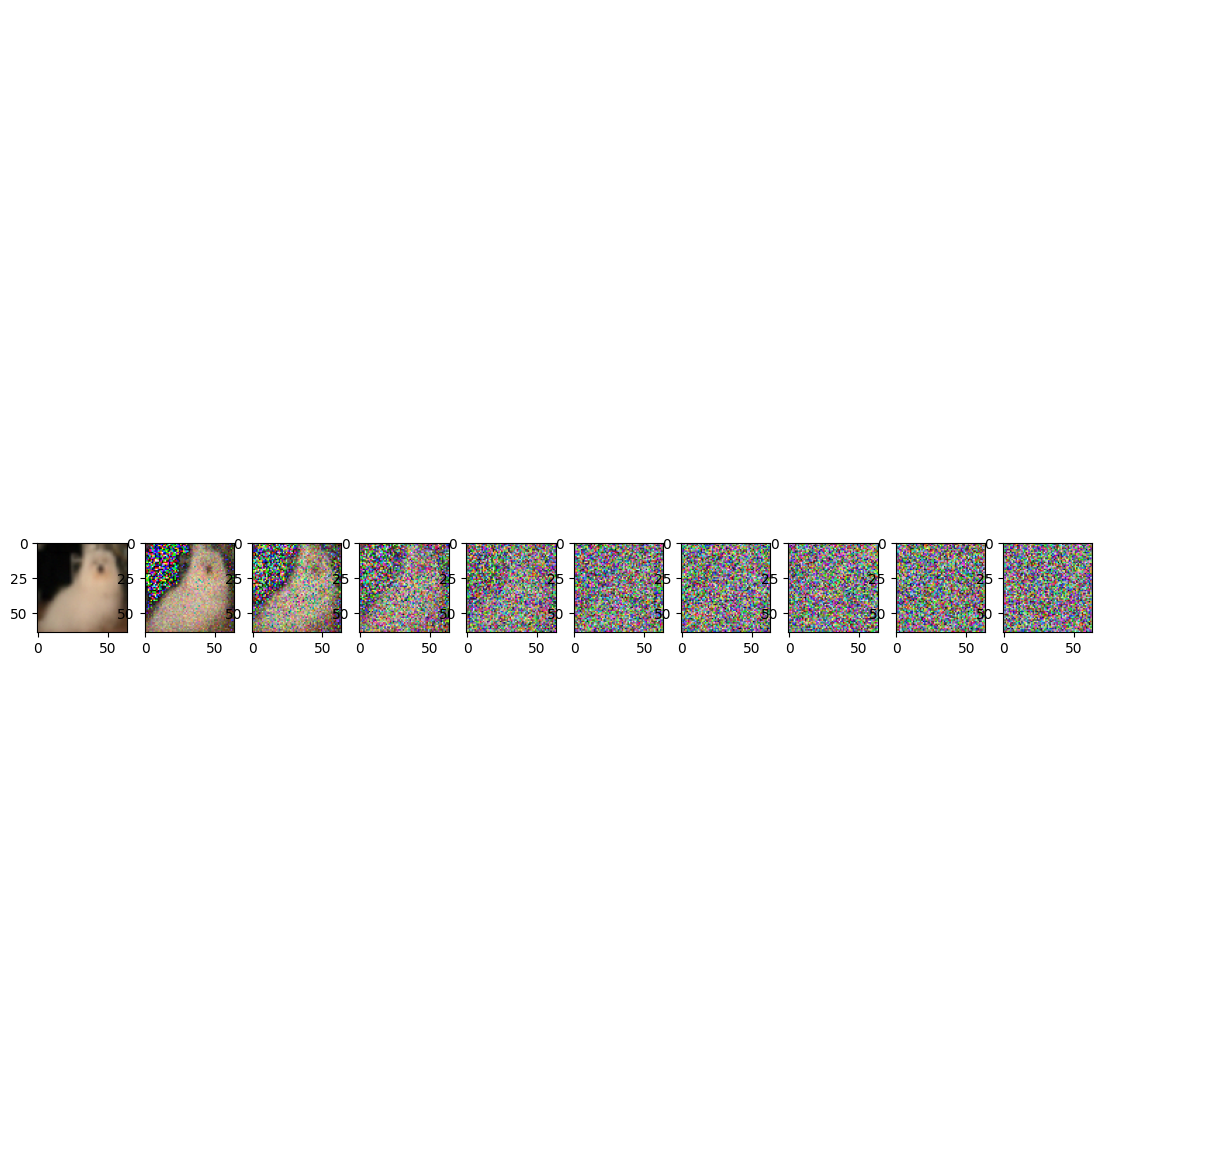

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Sampling (from Algorithm 2)


*  sample some noise
- from T to 1 we sample z from N(0,1), denoise the image progressively.
-


In [5]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumulative_products_t = get_index_from_list(
        sqrt_one_minus_alphas_cumulative_products, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumulative_products_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## UNET FOR REVERSE

1. UNET from OG PAPER!! to Predict noise instead of segmentation mask
2. Add timestep encoding to the UNET model
3. mean output (fixed variance)


<!-- variance can also be reparameterized and added on as a parameter but for simplicity, variance is fixed. -->

In [6]:
from torch import nn
import math

class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)
    if up:
      ## up channel - go big big big bigg from smol smol smol with 3x3 kernel
      self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4,2,1)
    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.relu = nn.ReLU()
    self.batch_norm1 = nn.BatchNorm2d(out_ch)
    self.batch_norm2 = nn.BatchNorm2d(out_ch)

  def forward(self, x, t, ):
    h = self.batch_norm1(self.relu(self.conv1(x)))
    time_emb = self.relu(self.time_mlp(t))
    time_emb = time_emb[(..., ) + (None, ) * 2]
    h = h + time_emb
    h = self.batch_norm2(self.relu(self.conv2(h)))
    return self.transform(h)

In [7]:
class PositionEmbeddings(nn.Module):
  def __init__(self,dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [8]:
class SimpleUnet(nn.Module):
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)

    out_dim = 3
    time_emb_dim = 32

    ## timestep stored as positional encoding in terms of sine
    self.time_mlp = nn.Sequential(
        PositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )


    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
    self.down_blocks = nn.ModuleList([
        Block(down_channels[i], down_channels[i+1], time_emb_dim)
        for i in range(len(down_channels)-1)
    ])
    self.up_blocks = nn.ModuleList([
        Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
        for i in range(len(up_channels)-1)
    ])

    ## readout layer
    self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

  def forward(self, x, timestep):
    t = self.time_mlp(timestep)
    x = self.conv0(x)
    residual_inputs = []
    for down in self.down_blocks:
      x = down(x, t)
      residual_inputs.append(x)
    for up in self.up_blocks:
      residual_x = residual_inputs.pop()
      x = torch.cat((x, residual_x), dim=1)
      x = up(x, t)
    return self.output(x)


In [9]:
model = SimpleUnet()
print(model)

SimpleUnet(
  (time_mlp): Sequential(
    (0): PositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tr

In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Traning loop

- sampling from dataset
- random t
- sample noise
- gradient descent of the model prediction on an image with sample noise added to predict the sample noise added
- repeat until convergence


Epoch 0 | step 000 Loss: 0.1743035763502121 


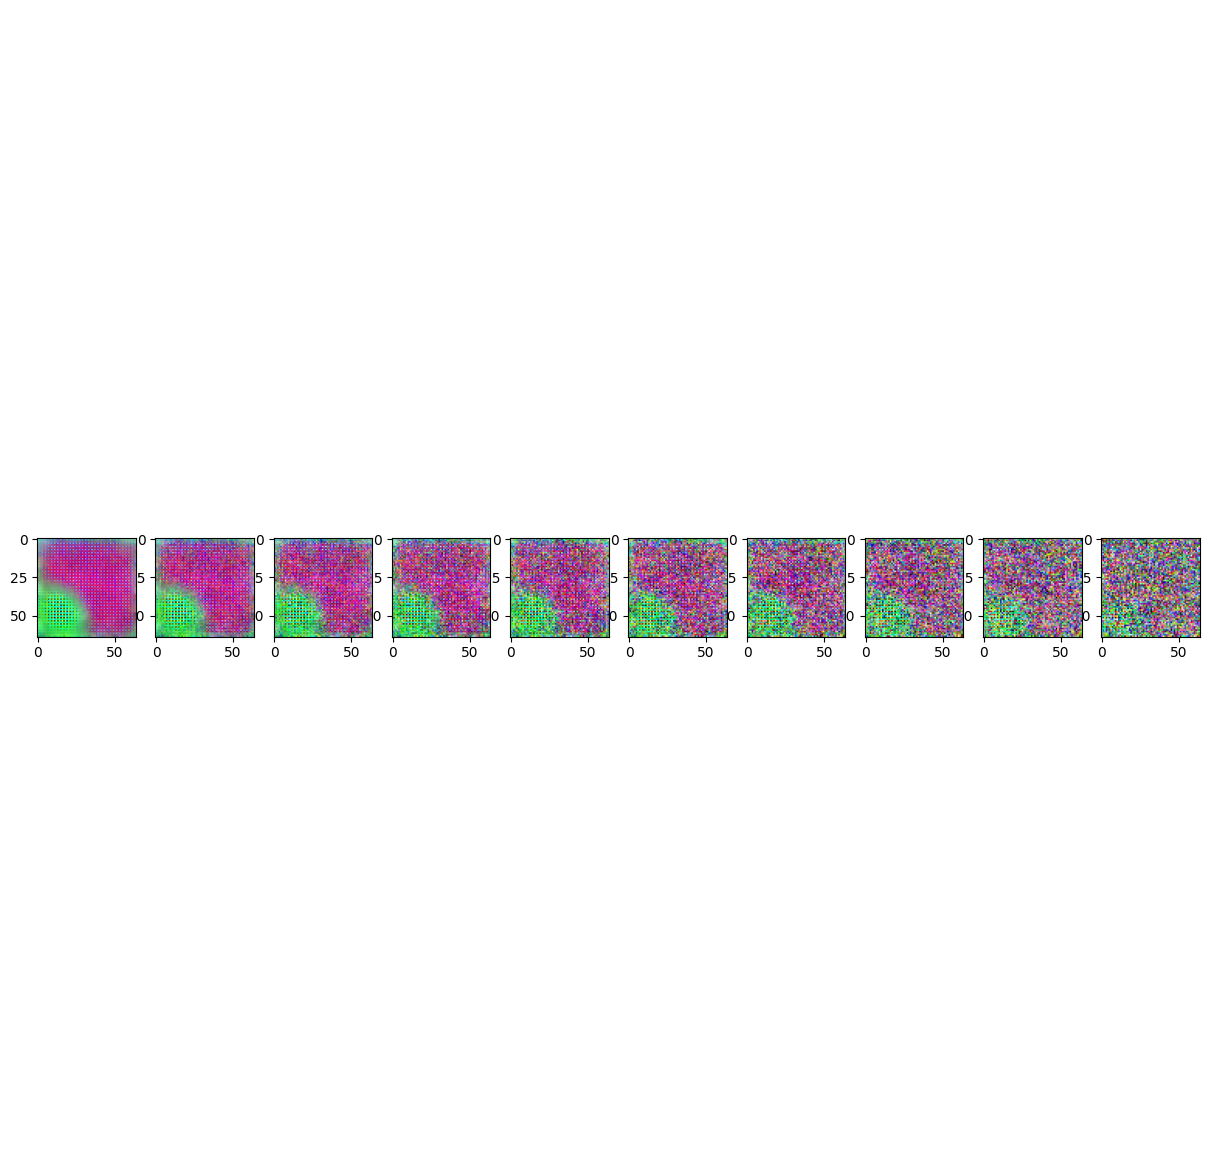

Epoch 0 | step 150 Loss: 0.13843095302581787 


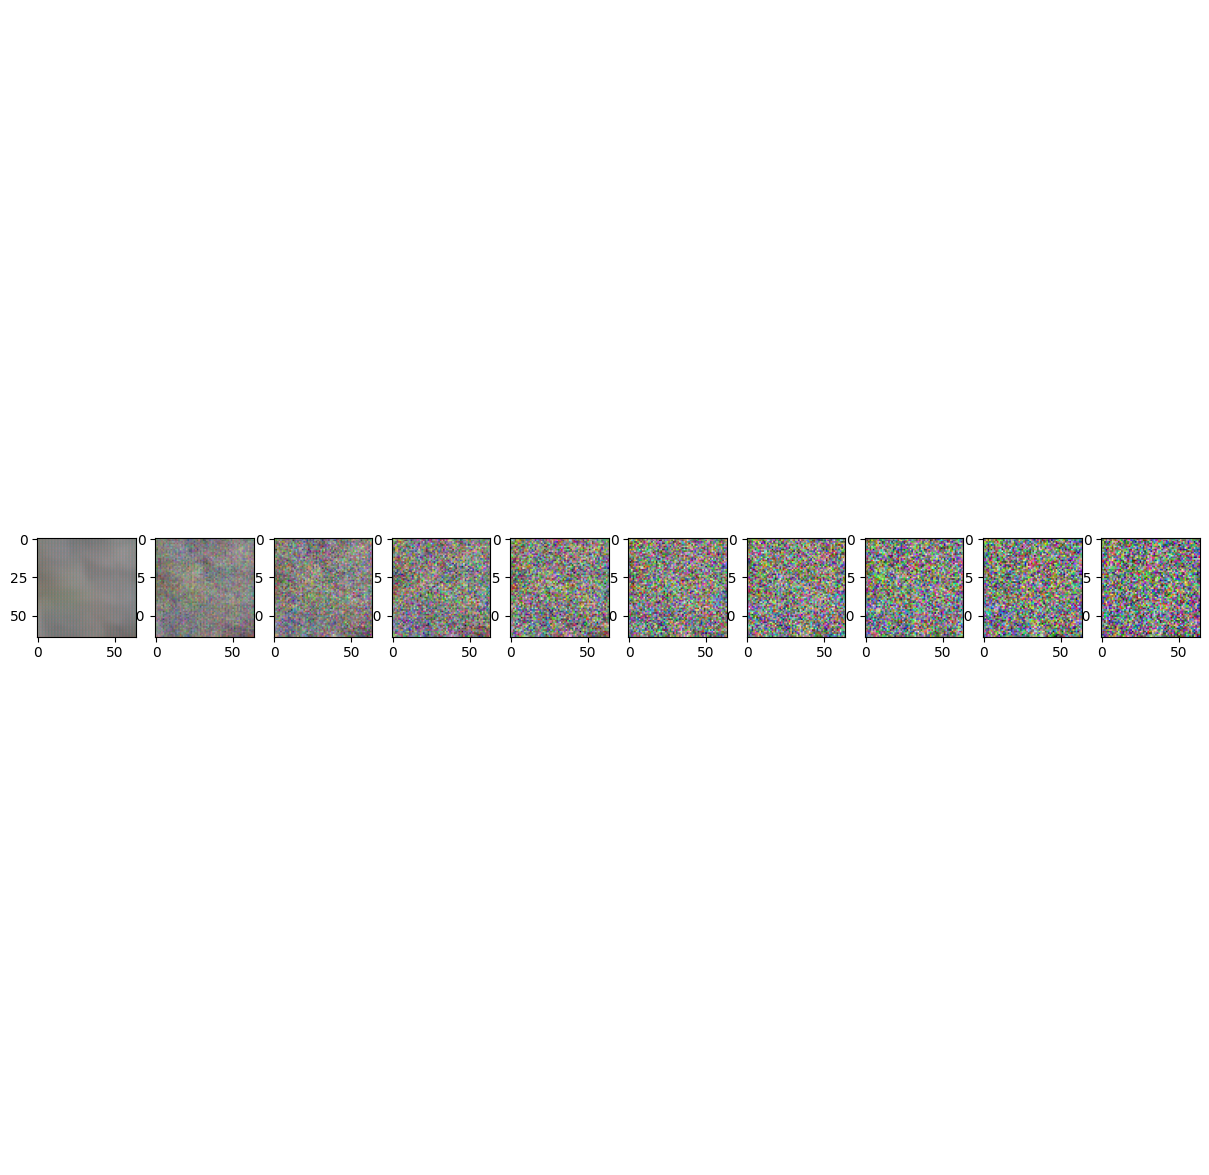

Epoch 0 | step 300 Loss: 0.12434052675962448 


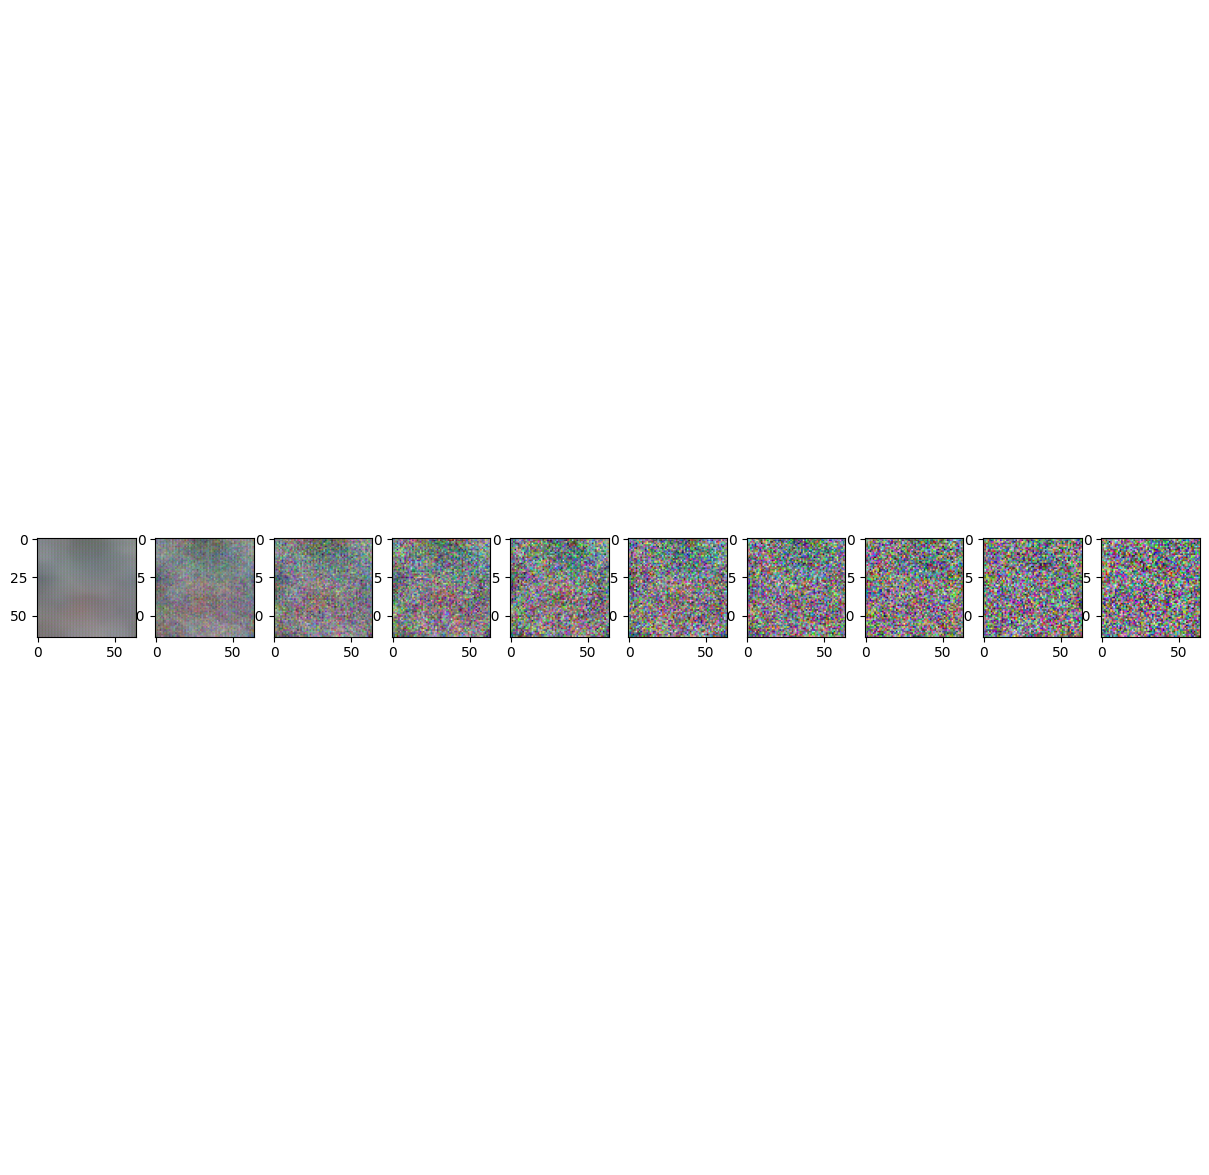

Epoch 1 | step 000 Loss: 0.1211625263094902 


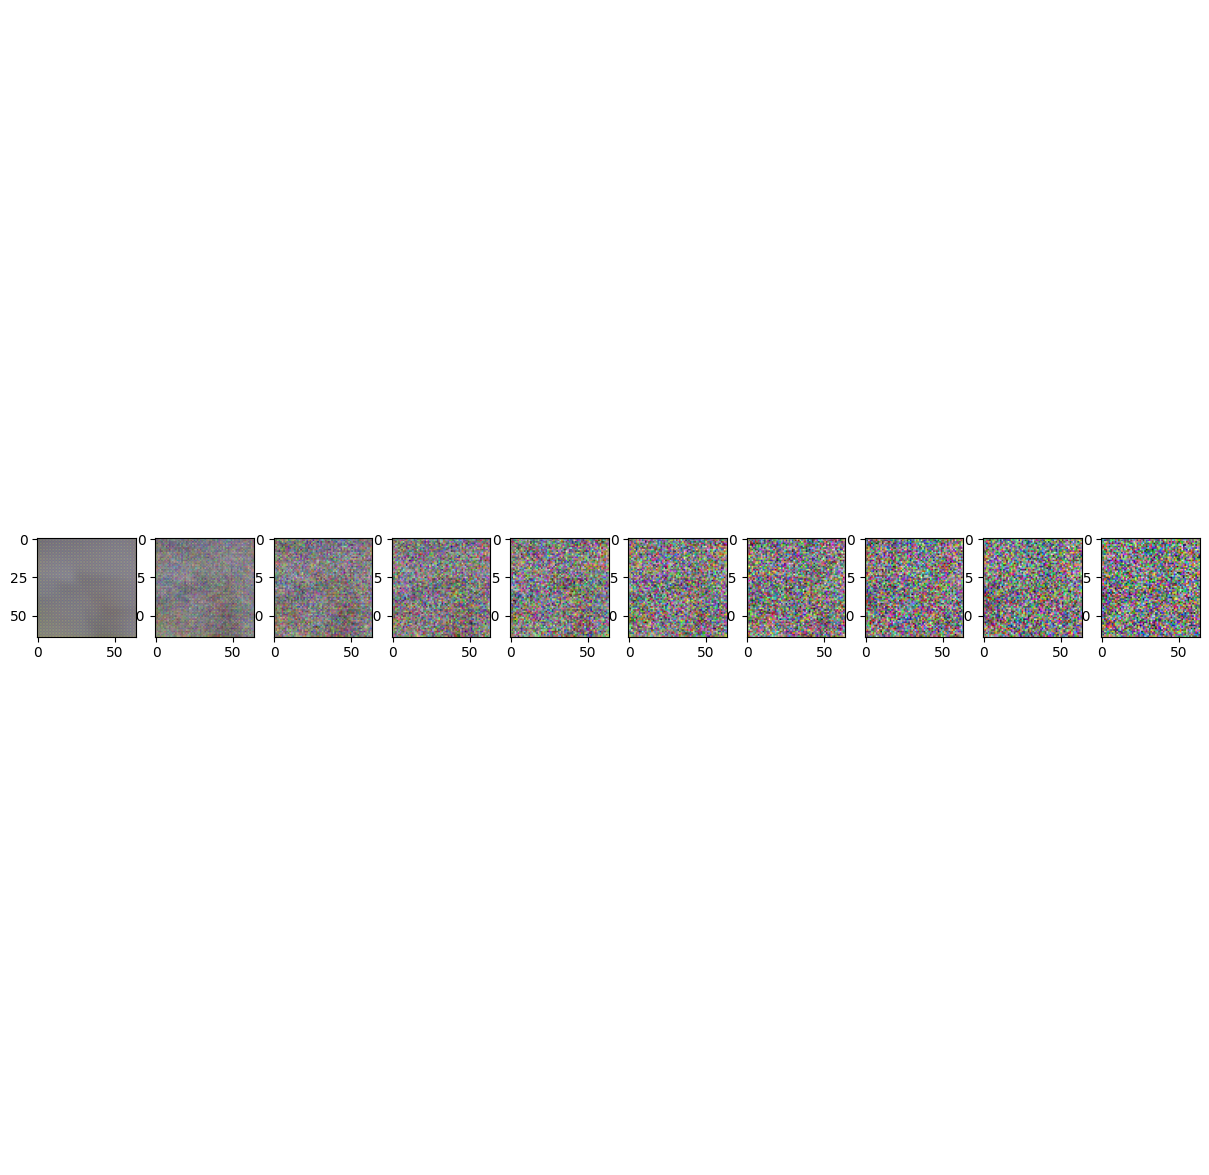

Epoch 1 | step 150 Loss: 0.1199573278427124 


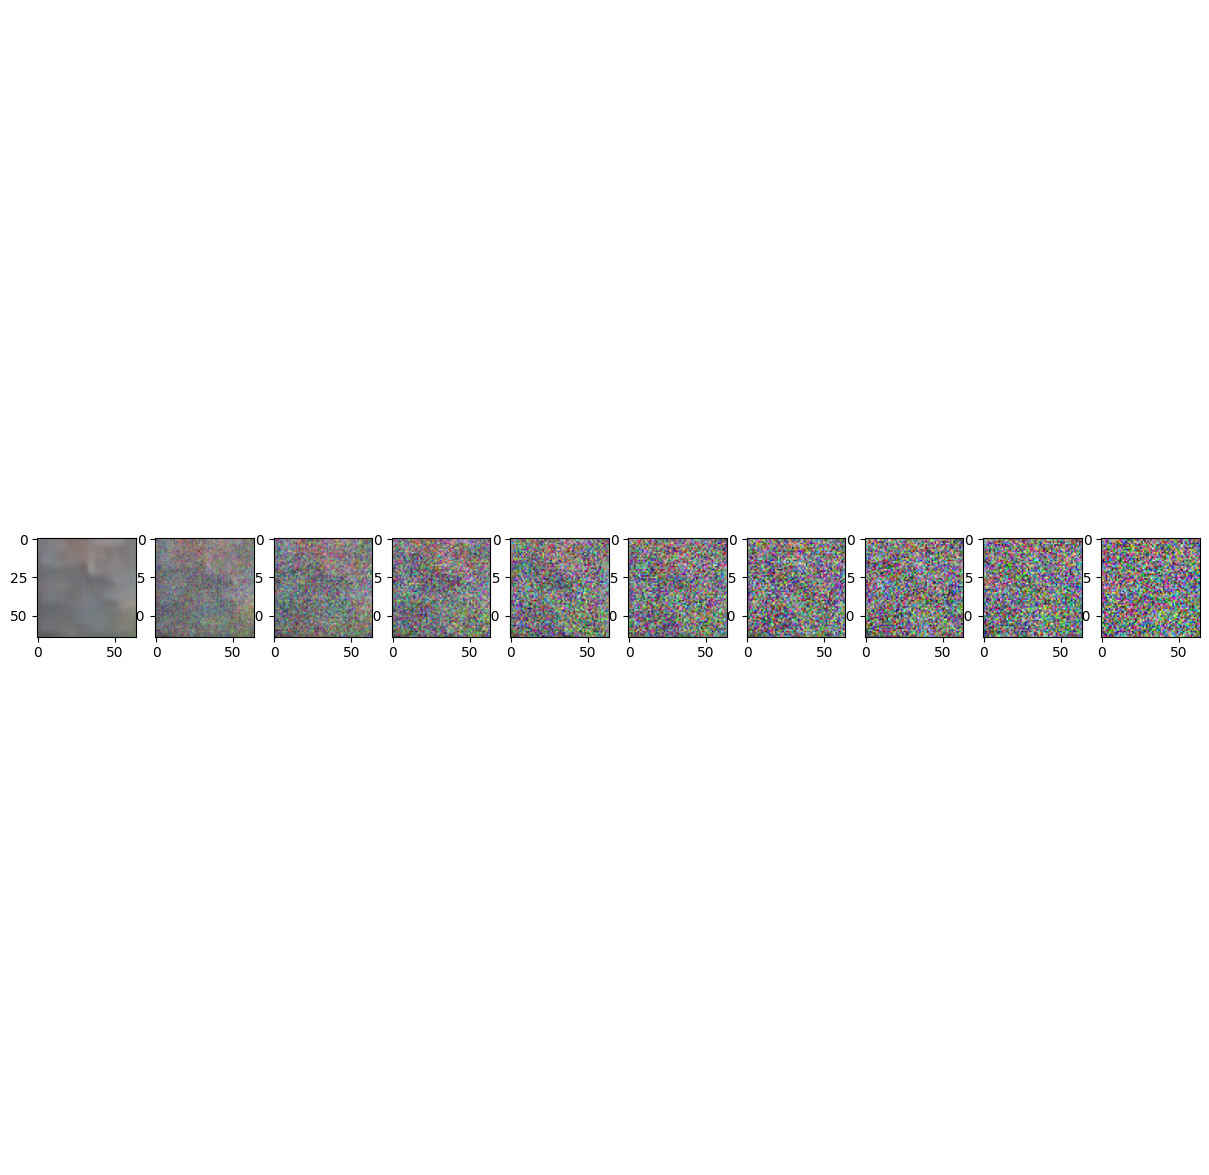

Epoch 1 | step 300 Loss: 0.1271609514951706 


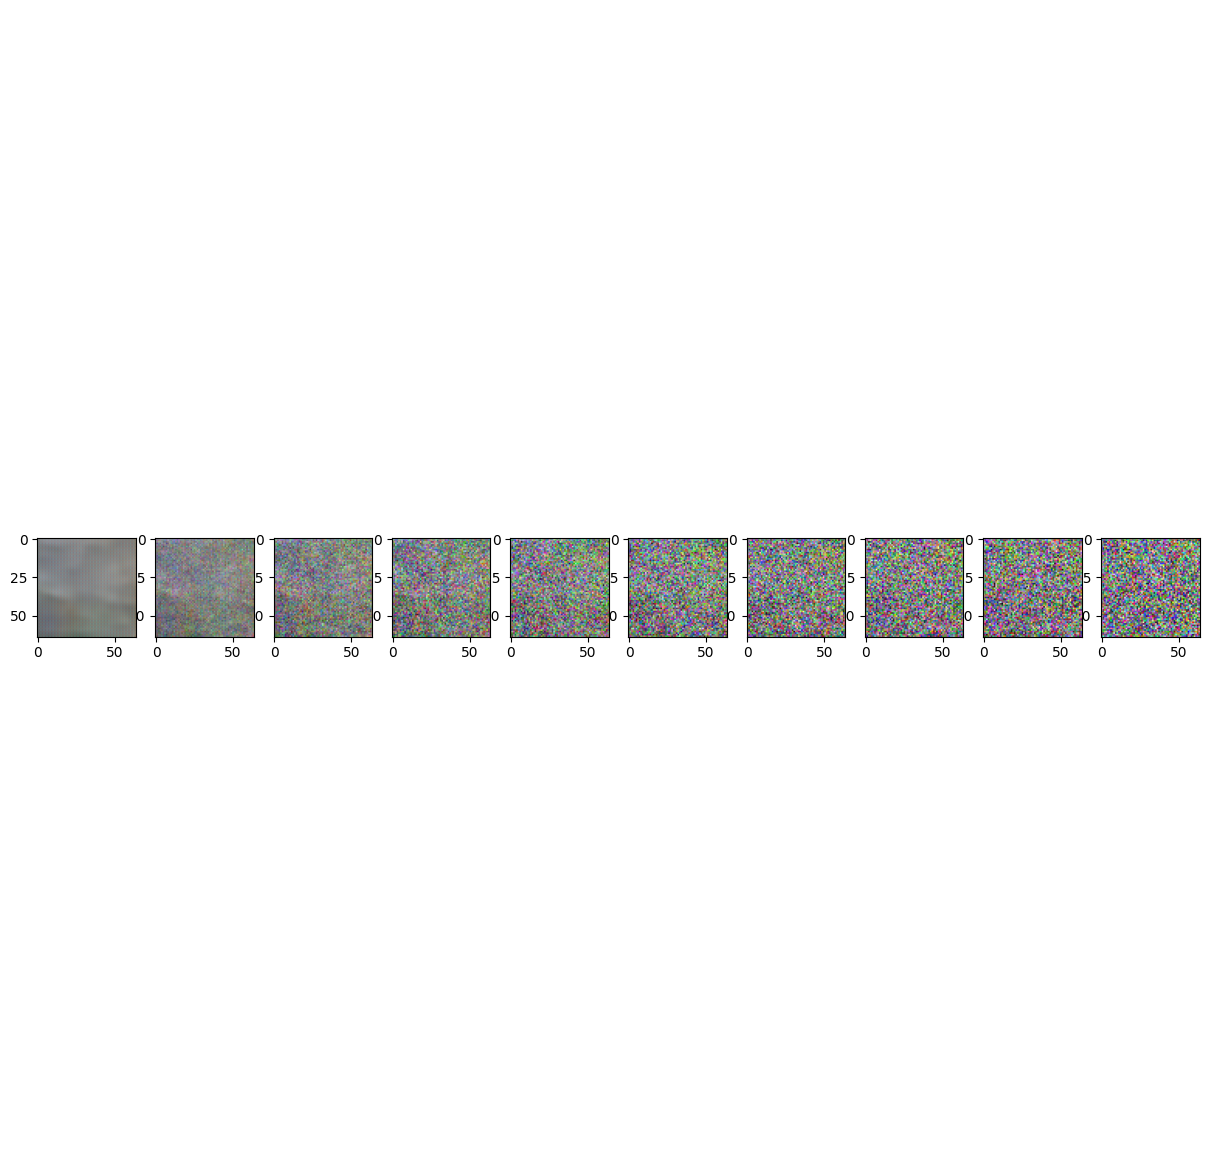

Epoch 2 | step 000 Loss: 0.129043310880661 


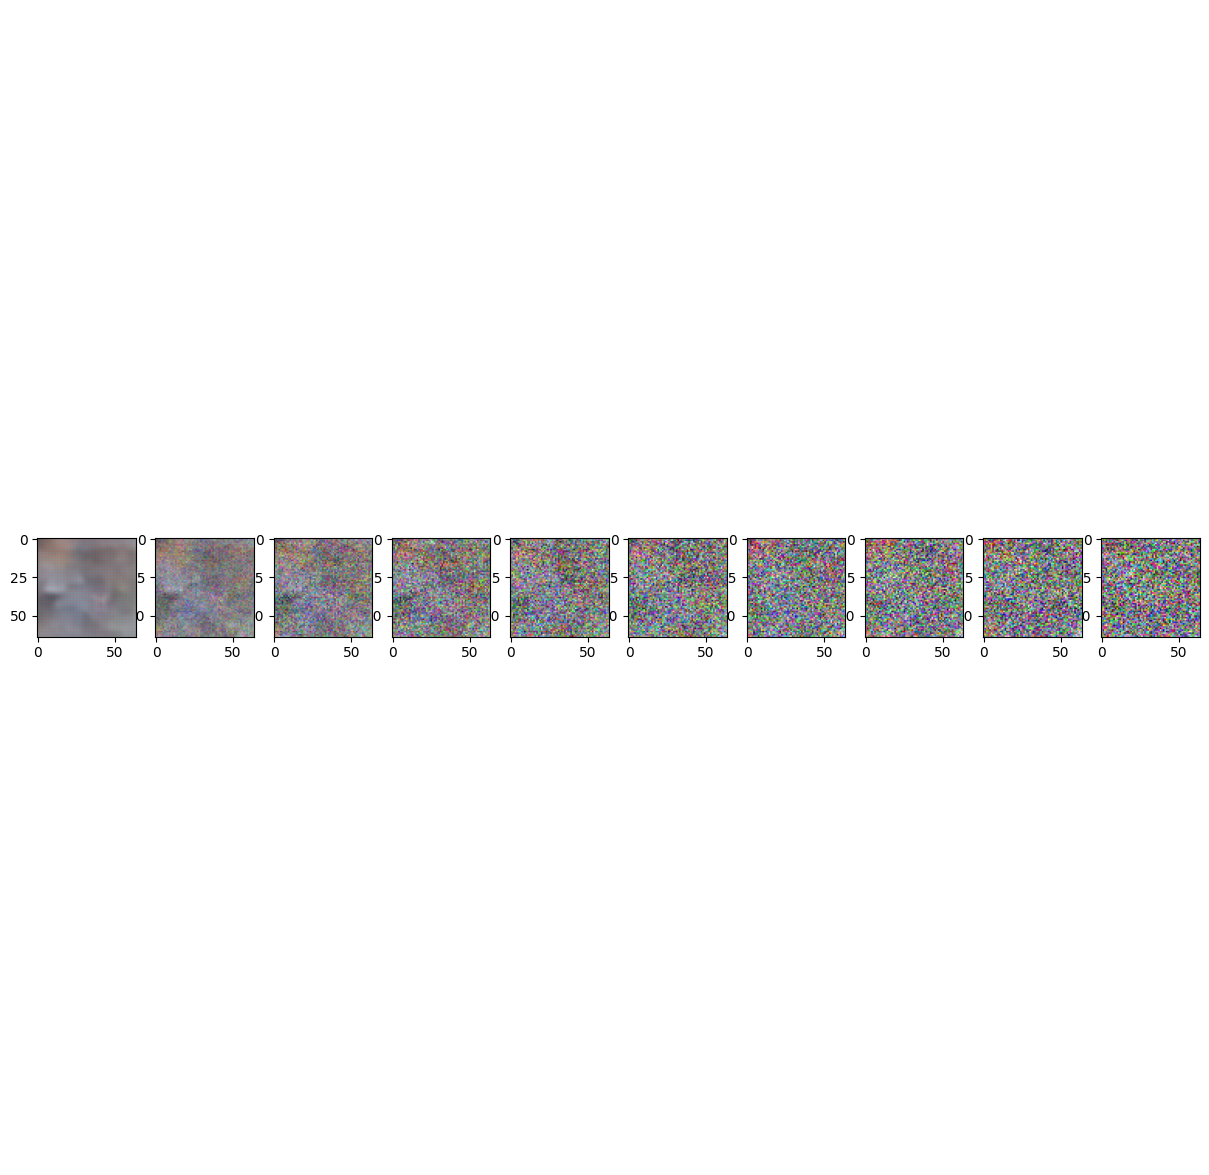

Epoch 2 | step 150 Loss: 0.1211780533194542 


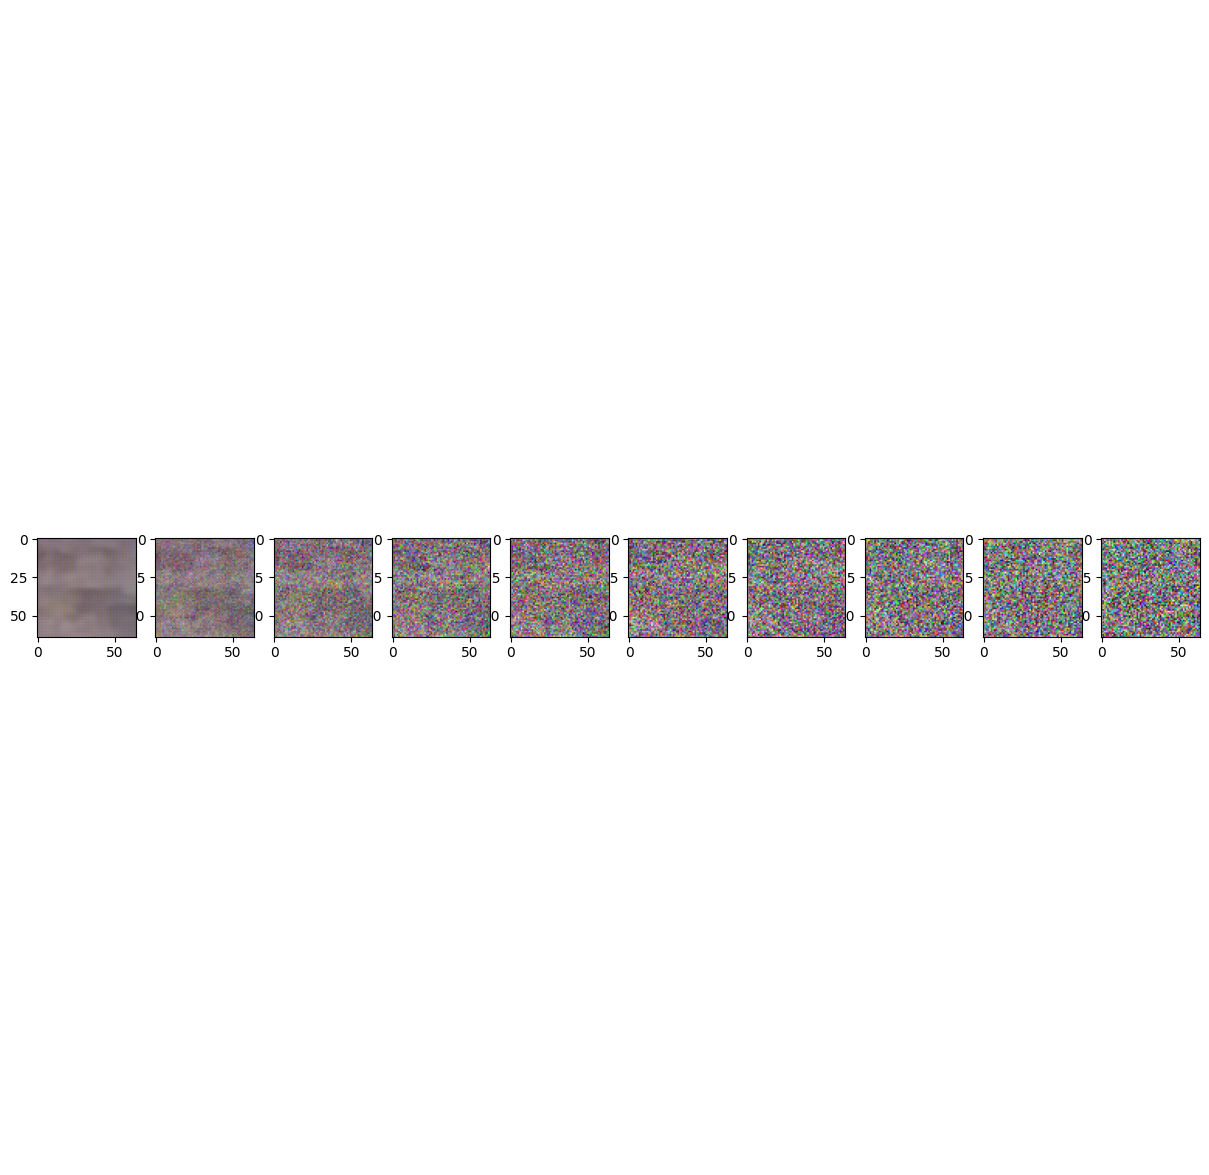

Epoch 2 | step 300 Loss: 0.10998731851577759 


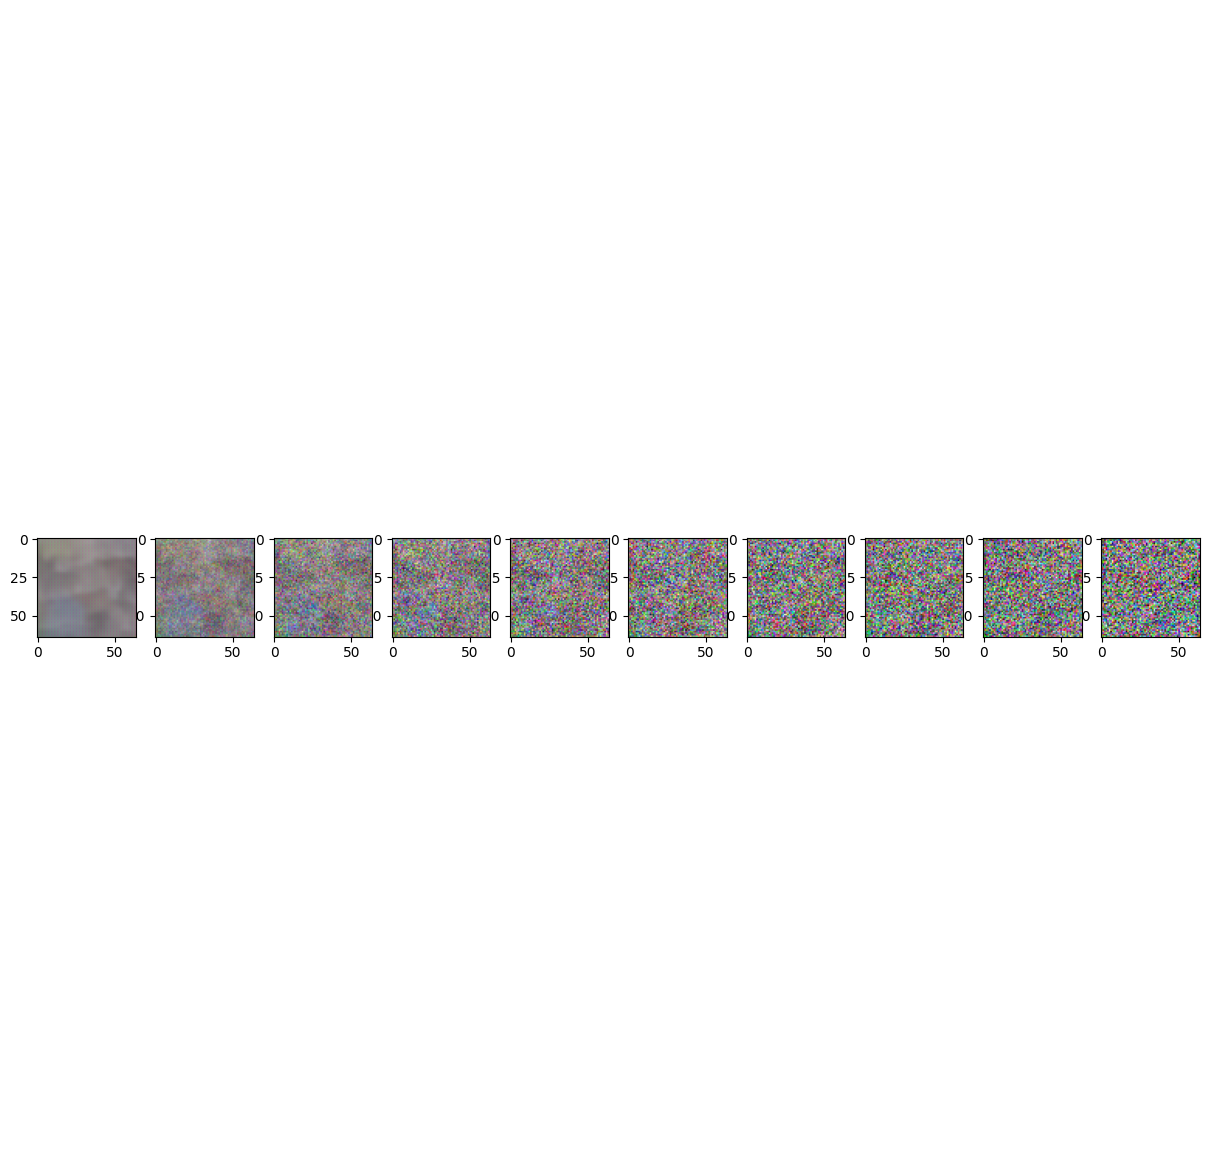

In [ ]:
## training loop
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 1 == 0 and step % 150 == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()